<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Проверка-моделей" data-toc-modified-id="Проверка-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка моделей</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    taxi = pd.read_csv('home/an4ouce/datasets/taxi.csv')

In [2]:
display(taxi.head())
display(taxi.info())
display(taxi.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Сразу преобразовали дату в формат datetime64 и сделали индексом. Видим, что количество заказов такси варьируется от 0 о 119. Проверим, расположены ли наши индексы в хронологическом порядке:

In [3]:
taxi.index.is_monotonic

True

Хронологический порядок соблюден. Выполним ресемплирование индексов по часу:

In [4]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь в датафрейме показано суммарное количество заказов такси по часам. Приступим к анализу временного ряда.

## Анализ

Проведем декомпозицию, чтобы увидеть тренды и сезонность. 

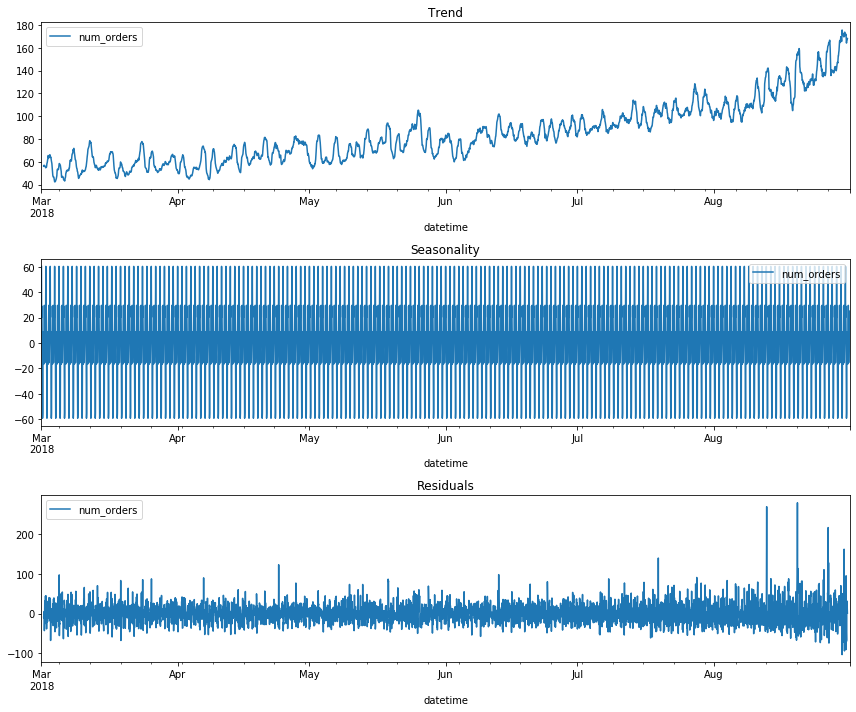

In [5]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

На первом графике явно заметен тренд к увеличению заказов. Вероятно, это связано с общей тенденцией демпинга цен на услуги такси; все больше людей могут это себе позволить.

На втором графике представлен стохастический стационарный процесс, так как распределение не зависит от времени.
Для получения более точной картины сезонности посмотрим поближе графики за последний день и последнюю неделю.

In [6]:
taxi.index.max()

Timestamp('2018-08-31 23:00:00')

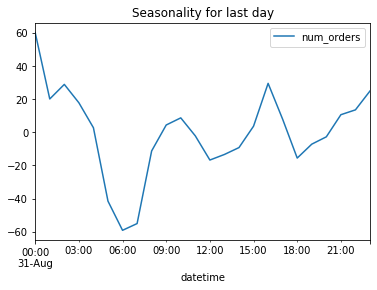

In [7]:
decomposed.seasonal['2018-08-31'].plot()
plt.title('Seasonality for last day')
plt.show()

На графике за день заметна зависимость количества заказов от времени суток. Основные заказы - с полночи до 3 часов, в это время не работает общественный транспорт, и пассажирам никак не добраться из аэропорта до города. Заметны пики в 10 и 16 часов. Вероятно, это связано с расписанием прилета.

Посмотрим на зависимость по дням недели:

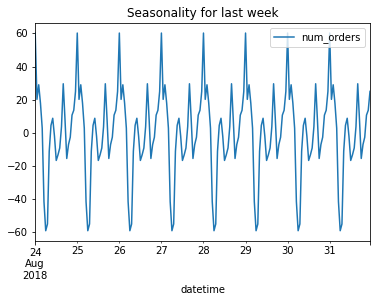

In [8]:
decomposed.seasonal['2018-08-24':'2018-08-31'].plot()
plt.title('Seasonality for last week')
plt.show()

Зависимости нет. Услуги такси востребованы в любой день.

Теперь создадим признаки для обучения моделей: добавим календарные признаки, отстающие значения и скользящее среднее.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [10]:
taxi_new = make_features(taxi, 24*7, 1)
taxi_new.head(10)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0


Разделим датасет на обучающую и тестовую выборку. Доля тестовой - 10% данных.

In [11]:
train, test = train_test_split(taxi_new, test_size=0.1, shuffle=False, random_state = 123)

print('Размер обучающей выборки: ', train.shape)
print('Размер тестовой выборки: ', test.shape)

Размер обучающей выборки:  (3974, 173)
Размер тестовой выборки:  (442, 173)


Отсутствующие значения в обучающей выборке нам не удастся заполнить - нет исторический данных. Удалим строки с пропусками.

In [12]:
train = train.dropna()
train.shape

(3806, 173)

На всякий случай проверим корректность разделения на выборки: нужно, чтобы тестовая выборка шла за обучающей, чтобы не нарушить порядок временного ряда.

In [13]:
train.index.max()

Timestamp('2018-08-13 13:00:00')

In [14]:
test.index.min()

Timestamp('2018-08-13 14:00:00')

Порядок не нарушен. Разделим обучающую и тестовую выборку на признаки и целевой признак (количество заказов).

In [15]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

print('Размер таблицы признаков обучающей выборки:', features_train.shape)
print('Размер таблицы признаков тестовой выборки:', features_test.shape)

Размер таблицы признаков обучающей выборки: (3806, 172)
Размер таблицы признаков тестовой выборки: (442, 172)


Признаки готовы к обучению моделей.

## Обучение

Создадим функцию, вычисляющую RMSE модели. Будем ее использовать в каждой модели, чтобы не дублировать код.

In [16]:
def rmse(model):
    
    model.fit(features_train, target_train)   
    y_pred = model.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, y_pred))

    return rmse

Для временных ряов нельзя применять обычную кросс-валидацию, так как в некоторые моменты часть тестовой выборки может попасть в обучающую, и произойдет утечка целевого признака. Воспользуемся кросс-валидацией для временных рядов:

In [17]:
tssplit = TimeSeriesSplit(n_splits=3)

Рассмотрим следующие модели: LinearRegression, RandomForestRegressor, LGBMRegressor и CatBoostRegressor. Для каждой подберем гиперпараметры с помощью GridSearchCV.

In [18]:
model = LinearRegression()

search_space_linear = [{'fit_intercept': [True, False],
                        'normalize': [True, False]}]


gs_linear = GridSearchCV(model, 
                        search_space_linear, 
                        cv=tssplit, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

rmse_linear = rmse(gs_linear)

print('RMSE LinearRegression: ', round(rmse_linear, 0), 'заказов')

RMSE LinearRegression:  34.0 заказов


In [19]:
model = LGBMRegressor()

search_space_lgbm = [{'learning_rate': [0.01, 0.1],
                       'n_estimators': [100, 200],
                       'num_leaves': [31, 62]}]


gs_lgbm = GridSearchCV(model, 
                        search_space_lgbm, 
                        cv = tssplit, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')


rmse_lgbm = rmse(gs_lgbm)

print('RMSE LGBMRegressor: ', round(rmse_lgbm, 0), 'заказов')

RMSE LGBMRegressor:  37.0 заказов


In [20]:
model = CatBoostRegressor(loss_function='RMSE', silent=True)

search_space_catboost = [{'learning_rate': [0.03, 0.1],
                          'iterations': [40, 60, 80],
                          'depth': [3, 5]}]


gs_catboost = GridSearchCV(model, 
                        search_space_catboost, 
                        cv = tssplit, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

rmse_catboost = rmse(gs_catboost)

print('RMSE CatBoostRegressor: ', round(rmse_catboost, 0), 'заказов')

RMSE CatBoostRegressor:  39.0 заказов


In [21]:
model = RandomForestRegressor()

search_space_rf = [{'min_samples_split': [2, 5, 7],
                    'n_estimators': [130, 180, 230],
                    'max_depth': [5, 10, 15]}]


gs_rf = GridSearchCV(model, 
                        search_space_rf, 
                        cv=tssplit, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

rmse_rf = rmse(gs_rf)

print('RMSE RandomForestRegressor: ', round(rmse_rf, 0), 'заказов')

RMSE RandomForestRegressor:  39.0 заказов


## Проверка моделей

Сравним наши модели с константной:

In [22]:
dummy = DummyRegressor(strategy='mean')

rmse_dummy = rmse(dummy)

print('RMSE Dummy: ', round(rmse_dummy, 0), 'заказов')

RMSE Dummy:  84.0 заказов


In [23]:
pred_previous = test.shift(fill_value=train.iloc[-1]['num_orders'])

rmse_pred = np.sqrt(mean_squared_error(target_test, pred_previous['num_orders']))
print('RMSE по предыдущему значению: ', round(rmse_pred, 0), 'заказов')

RMSE по предыдущему значению:  59.0 заказов


In [24]:
data = {'RMSE, заказов':[rmse_linear, rmse_rf, rmse_lgbm, rmse_catboost, rmse_dummy, rmse_pred]}

table = pd.DataFrame(data)
table.index = ['LinearRegression', 'RandomForestRegressor','LGBMRegressor', 'CatBoostRegressor', 'DummyRegressor',
                                                                                        'По предыдущему значению']
pd.set_option('display.float_format', '{:.0f}'.format)
display(table)

,"RMSE, заказов"
LinearRegression,34
RandomForestRegressor,39
LGBMRegressor,37
CatBoostRegressor,39
DummyRegressor,84
По предыдущему значению,59


**Вывод:** все наши модели пресказывают лучше константной. Минимальная RMSE (41 заказ) у LGBMRegressor.